Worked in google colab

### Download dataset from kaggle using API key

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload();  # kaggle api key

Saving kaggle.json to kaggle.json


In [ ]:
!echo ~

/root


In [3]:
!mkdir ~/.kaggle/ && mv kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 400 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s IMDB

ref                                                             title                                   size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ashirwadsangwan/imdb-dataset                                    IMDb Dataset                             1GB  2023-03-04 04:38:56          14388        250  0.8235294        
harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows  IMDB Movies Dataset                    175KB  2021-02-01 07:35:48          22799        270  1.0              
lakshmi25npathi/imdb-dataset-of-50k-movie-reviews               IMDB Dataset of 50K Movie Reviews       26MB  2019-03-09 06:32:21         105329        865  0.8235294        
sankha1998/tmdb-top-10000-popular-movies-dataset                Popular Movies of IMDb                   1MB  2023-03-04 06:3

In [5]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 54% 14.0M/25.7M [00:00<00:00, 63.0MB/s]
100% 25.7M/25.7M [00:00<00:00, 85.5MB/s]


In [6]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


### Preprocessing

In [7]:
import nltk
import pandas as pd
import numpy as np

from tqdm import tqdm

tqdm.pandas()

In [8]:
df = pd.read_csv('/content/IMDB Dataset.csv')

In [9]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [11]:
#Deleting extra characters
import string
spec_chars = string.punctuation + '\d\n\xa0«»\t—…' 

df['clear'] = df['review'].str.lower().str.replace(f'[{spec_chars}]', '', regex=True)

In [12]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

df['tokens'] = df['clear'].progress_apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
100%|██████████| 50000/50000 [00:44<00:00, 1123.17it/s]


In [13]:
%%time
#Applying stemming and removing stopwords

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
stops = set(stopwords.words('english'))
stemmer = SnowballStemmer("english") 

df['stem'] = df['tokens'].progress_apply(lambda x: ' '.join([i for i in x if i not in stops])).progress_apply(stemmer.stem)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 50000/50000 [00:09<00:00, 5223.41it/s]

CPU times: user 10.9 s, sys: 131 ms, total: 11 s
Wall time: 11.3 s


In [14]:
import seaborn as sns
counts = df['stem'].str.split().explode().value_counts().reset_index()

cc = counts['stem'].value_counts().reset_index()
cc.columns = ['Частота слова', 'Число слов с такой частотой']
cc.sort_values('Частота слова', inplace=True)
cc

,Частота слова,Число слов с такой частотой
0,1,97509
1,2,19969
2,3,9667
3,4,6242
4,5,4429
...,...,...
1203,38755,1
1204,50331,1
1205,74668,1
1475,81910,1


<AxesSubplot:>

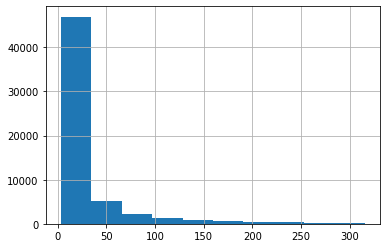

In [15]:
# Удалим редкие слова с маленькой и большой встречаемостью
max_border = cc.loc[cc['Число слов с такой частотой'] < 2, 'Частота слова'].min()
min_border = 2


counts.loc[(counts['stem'] > min_border) & (counts['stem'] < max_border), 'stem'].hist()

### Tokenization

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
#vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_df=max_border, min_df=min_border, norm=False)  # качество хуже
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), norm=None, min_df=min_border)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['stem'], df['sentiment'], test_size=0.3, random_state=123, stratify=df['sentiment'])

In [18]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [19]:
le = LabelEncoder()
le.fit(y_train);

# Fitting

In [ ]:
%%time
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

model = LGBMClassifier(random_state=123)
params = {
    'num_leaves': [5, 15, 31], # default=31
    'max_depth': [-1, 3, 7], # default=-1
    'learning_rate': [0.5, 0.1, 0.01], # default=0.1
}

clf = GridSearchCV(model, params, scoring='f1', verbose=10)
clf.fit(X_train, le.transform(y_train))

In [ ]:
clf.best_params_

{'learning_rate': 0.5, 'max_depth': -1, 'num_leaves': 31}

In [ ]:
# saving time after GridSearch
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

clf = LGBMClassifier(**{'learning_rate': 0.5, 'max_depth': -1, 'num_leaves': 31}, random_state=123)
clf.fit(X_train, le.transform(y_train));

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(le.transform(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      7500
           1       0.88      0.88      0.88      7500

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



### FastText emb + LGBM

In [ ]:
!pip install fasttext

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

In [ ]:
!gzip -d /content/cc.en.300.bin.gz

In [ ]:
import fasttext

ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
len(ft.get_words())

2000000

In [ ]:
embeddings = df['clear'].progress_apply(ft.get_sentence_vector)

100%|██████████| 50000/50000 [01:00<00:00, 831.14it/s] 


In [ ]:
embeddings[0].shape

(300,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(embeddings.tolist()), df['sentiment'], test_size=0.3, random_state=123, stratify=df['sentiment'])

In [ ]:
%%time
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

model = LGBMClassifier(random_state=123)
params = {
    'num_leaves': [5, 15, 31], # default=31
    'max_depth': [-1, 3, 7], # default=-1
    'learning_rate': [0.5, 0.1, 0.01], # default=0.1
}

clf = GridSearchCV(model, params, scoring='f1', verbose=10)
clf.fit(X_train, le.transform(y_train))

In [ ]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 31}

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(le.transform(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      7500
           1       0.84      0.85      0.84      7500

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



### FastText

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import fasttext

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['clear'], df['sentiment'], test_size=0.3, random_state=123, stratify=df['sentiment'])

In [ ]:
# Обучается очень долго, обучил на домашнем пк и закинул готовые веса сюда
# Лучше запустить следующую ячейку с уже обученной моделью
text = '\n'.join(X_train)

with open('unsupervised.txt', 'w', encoding='utf-8') as txt:
    txt.writelines(text)
    
model = fasttext.train_unsupervised('unsupervised.txt', epoch=10, dim=300)
model.save_model("ft.bin")

!mkdir  /content/drive/MyDrive/corpus
!mv ft.bin /content/drive/MyDrive/corpus/ft.bin

In [ ]:
!pip uninstall gdown -y && pip install gdown
!gdown -V
!gdown 1acMmF_zTEFKnDwtgB5VNtHD--W6fzjZb

model = fasttext.load_model('/content/ft.bin')

In [ ]:
#import fasttext
#model = fasttext.load_model('/content/drive/MyDrive/corpus/ft.bin')
def save_vec_format(model, path):
    words = model.get_words()

    with open(path,'w', encoding='utf-8') as file_out:

        # the first line must contain number of total words and vector dimension
        file_out.write(str(len(words)) + " " + str(model.get_dimension()) + "\n")

        # line by line, you append vectors to VEC file
        for w in words:
            v = model.get_word_vector(w)
            vstr = ""
            for vi in v:
                vstr += " " + str(vi)
            try:
                file_out.write(w + vstr+'\n')
            except:
                pass
            
save_vec_format(model, "ft.vec")

In [ ]:
text = X_train.to_frame()
text['format'] = np.where(y_train == 'positive', '__label__pos ', '__label__neg ') + text['clear']
text = '\n'.join(text['format'])

In [ ]:
with open('supervised.txt', 'w', encoding='utf-8') as txt:
    txt.writelines(text)

In [ ]:
model = fasttext.train_supervised('supervised.txt', pretrainedVectors="ft.vec", epoch=3, ws=5, dim=300)

In [ ]:
pred = model.predict(X_test.to_list())
y_pred = np.where(np.array(pred[0]).squeeze() == '__label__pos', 1 , 0)

In [ ]:
print(classification_report(np.where(y_test == 'positive', 1, 0), 
                            y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7500
           1       0.89      0.90      0.90      7500

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



Fasttext + LGBM

In [ ]:
embeddings = df['clear'].progress_apply(model.get_sentence_vector)

100%|██████████| 50000/50000 [02:30<00:00, 331.96it/s]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(embeddings.tolist()), df['sentiment'], test_size=0.3, random_state=123, stratify=df['sentiment'])

In [ ]:
model = LGBMClassifier(random_state=123)
params = {
    'num_leaves': [5, 15, 31], # default=31
    'max_depth': [-1, 3, 7], # default=-1
    'learning_rate': [0.5, 0.1, 0.01], # default=0.1
}

clf = GridSearchCV(model, params, scoring='f1', verbose=10)
clf.fit(X_train, le.transform(y_train))

In [ ]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 31}

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(le.transform(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      7500
           1       0.86      0.87      0.86      7500

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



Вывод - в данном случае, лучше использовать собственные эмбеддинги

### FastText + TF-IDF

In [ ]:
# модель с предыдущего шага с собственными эмбеддингами

model = fasttext.load_model('/content/ft.bin')

In [ ]:
vocab = model.get_words()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['stem'], df['sentiment'], test_size=0.3, random_state=123, stratify=df['sentiment'])

#vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), norm=False, min_df=min_border)
vectorizer = TfidfVectorizer(vocabulary=vocab, norm=None, min_df=min_border)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
features = vectorizer.get_feature_names_out()

In [ ]:
from tqdm import tqdm

def get_sent_emb_with_tfidf(sents, vectorized):
    embeddings = []
    with tqdm(total=vectorized.shape[0]) as pbar:
        for n, row in enumerate(vectorized):
            _, idx = row.nonzero()
            tfidf = row[0, idx].toarray()[0]
            sent_emb = np.zeros(300)  # length of emb
            for t, i in zip(tfidf, idx):
                emb = model.get_word_vector(features[i])
                sent_emb += t * emb
            embeddings.append(sent_emb/np.linalg.norm(sent_emb))
            pbar.update(1)
        return np.array(embeddings)

In [ ]:
X_train_emb = get_sent_emb_with_tfidf(X_train, X_train_tfidf)

100%|██████████| 35000/35000 [03:18<00:00, 176.33it/s]


In [ ]:
X_test_emb = get_sent_emb_with_tfidf(X_test, X_test_tfidf)

100%|██████████| 15000/15000 [01:20<00:00, 185.58it/s]


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

model = LGBMClassifier(random_state=123)
params = {
    'num_leaves': [5, 15, 31], # default=31
    'max_depth': [-1, 3, 7], # default=-1
    'learning_rate': [0.5, 0.1, 0.01], # default=0.1
}

clf = GridSearchCV(model, params, scoring='f1', verbose=10)
clf.fit(X_train_emb, le.transform(y_train))

In [ ]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 31}

In [ ]:
y_pred = clf.predict(X_test_emb)
print(classification_report(le.transform(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7500
           1       0.85      0.85      0.85      7500

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



trying to use linear classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=123, solver='saga', penalty='elasticnet')
params = {
    'C': [0.5, 1.0, 2.0], # default=1
    'l1_ratio' : [0, 0.3, 0.5, 0.7, 1.0]  # default=None
}

clf = GridSearchCV(model, params, scoring='f1', verbose=10)
clf.fit(X_train_emb, le.transform(y_train))

In [ ]:
clf.best_params_

{'C': 2.0, 'l1_ratio': 0.5}

In [ ]:
y_pred = clf.predict(X_test_emb)
print(classification_report(le.transform(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      7500
           1       0.87      0.88      0.87      7500

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



# Итог

<table>
    <thead>
        <tr>
            <th colspan="1">Method</th>
            <th colspan="2">F1</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>TF-IDF + LGBM</td>
            <td>0.88</td>
        </tr>
        <tr>
            <td>Fasttext pre-trained emb + LGBM</td>
            <td>0.84</td>
        </tr>
        <tr>
            <td>Fasttext trained emb + Fasttext classifier</td>
            <td>0.90</td>
        </tr>
        <tr>
            <td>Fasttext trained emb + LGBM</td>
            <td>0.86</td>
        </tr>
        <tr>
            <td>Fasttext trained emb + TF-IDF + LGBM</td>
            <td>0.85</td>
        </tr>
        <tr>
            <td>Fasttext trained emb + TF-IDF + linear clf</td>
            <td>0.87</td>
        </tr>
    </tbody>
</table>



1. TF-IDF + простой классификатор хороший pipeline 
2. Лучше обучать собственную модель cbow или skip-gram модель fasttext. И иметь собственные эмбеддинги
3. TF-IDF + эмбеддинги в данном случае показали спорное качество
4. Линейные классификаторы (насколько я понял, в библиотеке fasttext в методе `train_supervised` используется тоже линейный классификатор) могут показать лучший результат, чем градиентный бустинг 